In [ ]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

## **Schrödinger equation**: catching electrons in a bi-crystal

In [ ]:
from electron import *
import numpy as np

In [ ]:
u,S,M,V_as = FOMsolver(600, 400)
u.shape #100 time-step, 1900 stati (immaginari+reali)

(100, 1990)

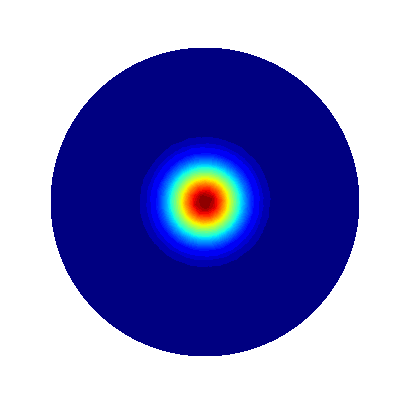

In [ ]:
from electron import probabilities

prob = probabilities(u)
fe.animate(prob, Vh)

In [ ]:
from electron import *

print(caught(prob))

0.9297114859288562


In [ ]:
np.random.seed(0)

EList=[] #lista di possible parameters values
uList=[]  #lista delle soluzioni relative ai parameters selezionati
nsim=30  #facciamo 100 simulazioni dello stesso problema

for j in range(nsim):
  E = np.random.uniform(0, 300)            # E ≥ 0
  deltaV0 = np.random.uniform(0, 1000)
  uj,S,M,V_as=FOMsolver(E,deltaV0)       #diamo 100 simulazioni da risolvere chiamando la funzione che implementa il problema da risolvere
  EList.append([E, deltaV0])    #aggiungiamo i parametri alla lista
  uList.append(uj)              #aggiungiamo alla lista le soluzioni (un vettore colonna)

#E=np.stack(EList)               #mettiamo i parametri dentro una matrice invece che una lista (vettore colonna), in quanto è più comodo
#u=np.stack(uList)               #mettiamo le soluzioni dentro una matrice invece che una lista, in quanto è più comodo

E=np.array(EList)
u=np.array(uList)
print(E.shape)

(30, 2)


+ Vediamo che nel for loop praticamente è stato accoppiata nella lista $\texttt{E}$ i valori del campo $\bar{E},\Delta V_0$ ho usato una lista con 2 colonne in quanto questi due termini sono i costrain del problema

In [ ]:
E
print(E.shape)

(30, 2)


+ Dato che ho praticamente fatto 30 simulazioni allora il vettore delle soluzioni $\texttt{u}$ dovrà contenere praticamente $\texttt{30,100,1990}$ cioè $n=30$ il numero di simulazioni, $n=100$ il numero di time-steps, $n=1990$ il numero di stati del problema dove $\texttt{:Vh.dim()}$ sono gli stati reali, mentre $\texttt{Vh.dim():}$ sono gli ultimi stati cioè quelli immaginari

In [ ]:
print(u.shape)

(30, 100, 1990)


per $t=10$ e della prima simulazione delle $30$ mostro i primi $3$ stati reali

995


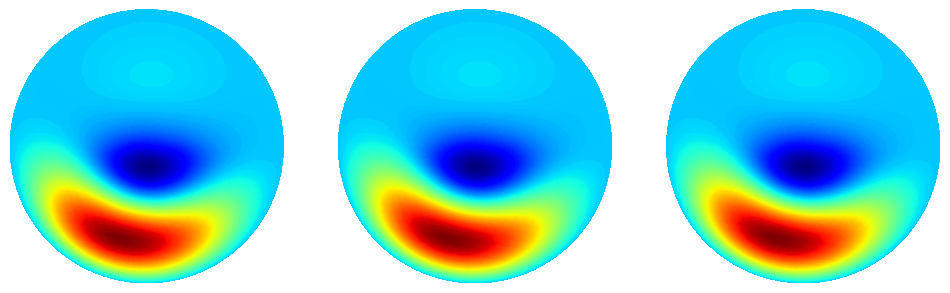

In [ ]:
t = 10
fe.multiplot([u[1, t, :Vh.dim()] for _ in range(3)], (1, 3), Vh)
print(Vh.dim())

Mostro la differenza tra uno stato reale e uno stato immaginario!

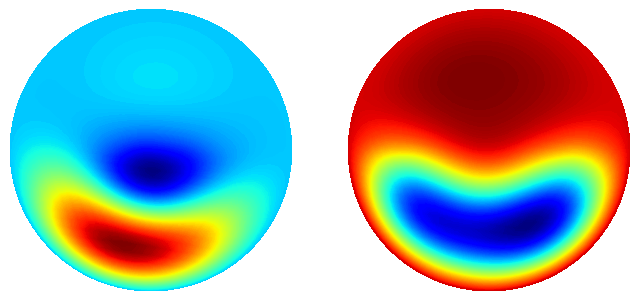

In [ ]:
fe.multiplot(
    [u[1, t, :Vh.dim()], u[1, t, Vh.dim():]],
    (1, 2), Vh
) #real vs immaginary part

In [ ]:
ntrain=15
utrain=u[:ntrain]
utrain.shape
ns,nt,nh=u.shape
utrain=utrain.reshape(1500,1990).T
print(utrain.shape)
#utrain_reshaped = utrain.reshape(-1, utrain.shape[-1])
#print(utrain_reshaped.shape)

(1990, 1500)


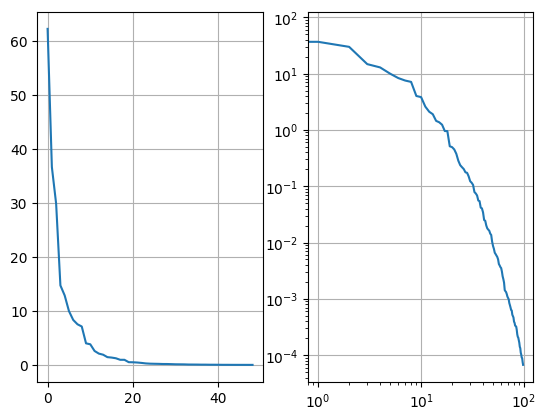

In [ ]:
# 3. Extraction of the POD basis

from scipy.linalg import svd
X,s,Yt=svd(utrain,full_matrices=False) #false significa che facciamo una SVD meno pesante, e meno accurata
plt.subplot(1,2,1)
plt.plot(s[1:50]) #plottiamo solo i primi 100 valori
plt.grid()
plt.subplot(1,2,2)
plt.loglog(s[1:100]) #plottiamo solo i primi 100 valori in modo da capire quante reduced basis abbiamo bisogno
plt.grid()

(1990, 30)


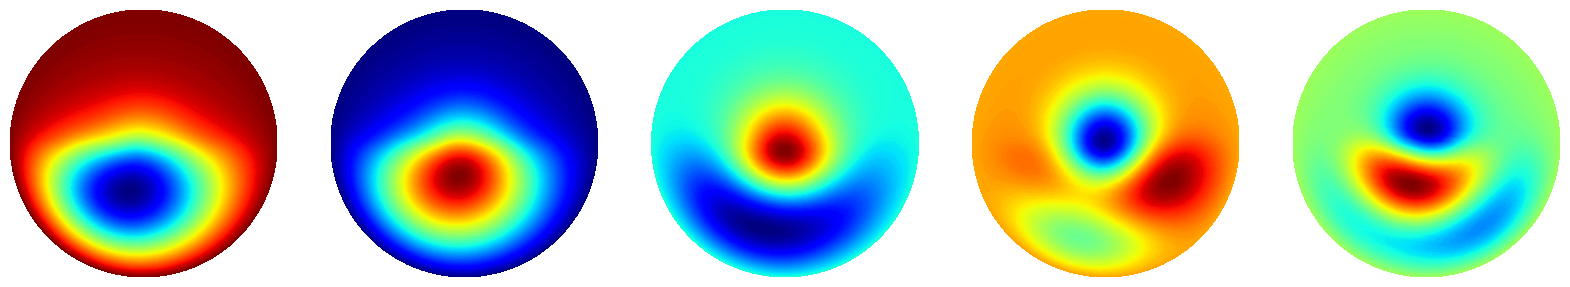

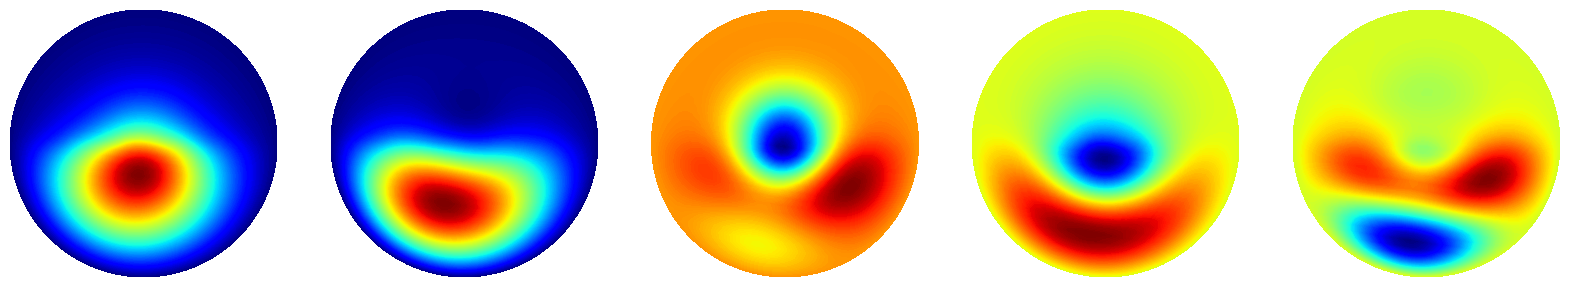

In [ ]:
n=30           #seleziono 35 basis functions perchè voglio tenere l'errore <1% e poi perchè singular-value arriva ad asintoto quindi sono legalizzato a farlo!
V=X[:,:n]      # creiamo la base con le prime n-colonne
print(V.shape) # Nh x N

fe.multiplot(V[:Vh.dim(),:5].T,(1,5),Vh) #plottiamo le prime 5 basi "reali"
fe.multiplot(V[Vh.dim():,:5].T,(1,5),Vh) #plottiamo le prime 5 basi "immaginarie"

In [ ]:
# 4. Projection error over the test set

#proiettiamo l'intero data-set sullo spazio V
print(u.reshape(3000,1990).shape) # Ns x Nt, Nh
uproj= (u.reshape(3000,1990) @ V @ V.T).reshape(30,100,1990) #questa è la proiezione sulla base ridotta u @ V @ V.T
print(uproj.shape) #con reshape(ns,nt,nh) riotteniamo la stessa dimensione degli original data u, solo che uproj sono i dati FOM proiettati sullo spazio ridotto, ora noi riotteniamo la stessa dimensione del detaset iniziale perche vogliamo calcolare l'errore dovuto a questa approssimazione

(u-uproj).shape
#calcolo l'errore tra i data-set FOM e i data-set proiettati su V
errors=(np.linalg.norm(u-uproj,axis=2)/np.linalg.norm(u,axis=2)).max(axis=1) #usiamo axis=2 in quanto abbiamo da fare la norma sulla dimesione dei valori 4033, poi axis=1 in quanto prendiamo il massimo dei tempi... questo è l'errore commesso durante la proiezione sullo spazio ridotto
num2p(errors[ntrain:].mean()) #significa che l'errore massimo è 0.98%, perchè [ntrain:] ?? l'errore oltre il test-set !

(3000, 1990)
(30, 100, 1990)


'1.41%'

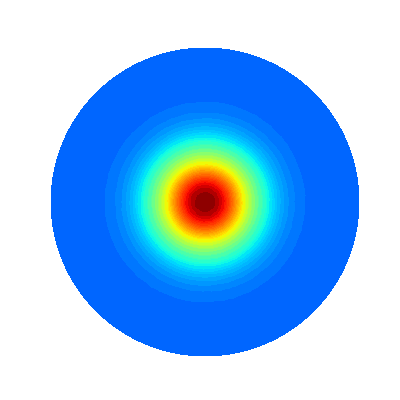

In [ ]:
fe.animate(u[20, :, :Vh.dim()],Vh) #animazione del test, fuori dal training cioè sui dataset n=20 (:Vh.dim(), cioè la parte reale)

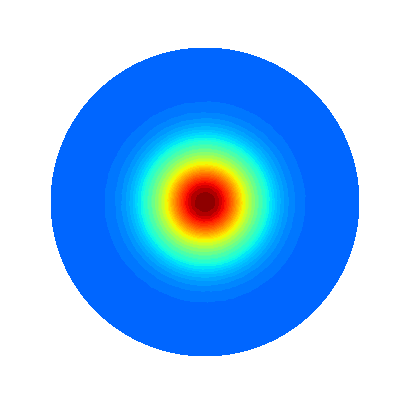

In [ ]:
fe.animate(uproj[20, :, :Vh.dim()],Vh) #animazione di u-projected sullo spazio V (spazio ridotto) simulazione n=20 (fuori dal training-set), time-step=:, dimensione n=:Vh.dim() (solo parte reale)

## Assembling

+ la cosa particolare è che prendo $\texttt{V[:Vh.dim()]}$ cioè solo la porzione reale in modo da assemblare solo la parte reale, non la immaginaria

+ non sono sicuro di questo in quanto secondo me bisogna prendere anche la parte immaginaria di V... nel caso mi rendo conto che ci siano problemi bisogna eliminarare dalla funzione $\texttt{FOMsolve()}$ nel $\texttt{return}$ la sequenza $\texttt{,S,M,V}$


In [ ]:
from fenics import *
#Dh = fe.space(mesh, 'DG', 0)
f1 = fe.interpolate(lambda x: x[0], Vh)
f2 = fe.interpolate(lambda x: np.where(x[1] > 0, 1.0, 0.0), Vh)

A1 = fe.assemble(lambda u, v: f1 * u * v * dx, Vh)
A2 = fe.assemble(lambda u, v: f2 * u * v * dx, Vh)

S = fe.assemble(lambda u, v: inner(grad(u), grad(v))*dx, Vh)
M = fe.assemble(lambda u, v: u*v*dx, Vh)

print(A1.shape,E.shape)
#V_aff = E[1,0] * A1 + E[1,1] * A2 #va fatto dopo che ho ridotto! per far combaciare le dimensioni ed E[1,0] ed E[1,1] deve essere SEMPRE UNO SCALARE!

(995, 995) (30, 2)


## Off-line projection

+ costruisco prima le matrici a blocchi
+ faccio la proiezione sullo spazio ridotto $\mathbb{V}$

In [ ]:
from scipy.sparse import block_diag
from scipy.sparse import bmat
print(M.shape,V[:Vh.dim()].shape,S.shape,V_as.shape)



M_big = bmat([
    [M,None ],
    [None, M]
])

A1_big = bmat([
    [None, -A1],
    [A1, None]
])

A2_big = bmat([
    [None, -A2],
    [A2, None]
])

S_big = bmat([
    [None, -S],
    [S, None]
])
B_big=S_big+A1_big+A2_big

"""M_big = block_diag([M, M])
A1_big = block_diag([A1, A1])
A2_big = block_diag([A2, A2])
S_big= block_diag([S,S])
#B = S + A1 + A2 #V_as
B_big = block_diag([B, -B]) #rispettare il block diag- del pdf cioè Re, Im"""

print(M_big.shape,B_big.shape,S_big.shape)

Mrb=V.T @ M_big @ V
Brb=V.T @ B_big @ V
A1rb= V.T @ A1_big @ V
A2rb=V.T @ A2_big @ V
Srb= V.T @ S_big @ V
print(Mrb.shape,Brb.shape,A1rb.shape,A2rb.shape,Srb.shape)

(995, 995) (995, 30) (995, 995) (995, 995)
(1990, 1990) (1990, 1990) (1990, 1990)
(30, 30) (30, 30) (30, 30) (30, 30) (30, 30)


# Initial Conditions
converto le condizioni iniziali per la funzione d'onda reale e immaginaria in vettori da usare dentro le funzioni per la soluzione del problema
+ $\Psi_{\mathbb{R}}\rightarrow $ vector
+  $\Psi_{\mathbb{C}}\rightarrow $ vector

In [ ]:
import numpy as np


u0_real = fe.interpolate(lambda x: np.exp(-100*(x[0]**2+x[1]**2)), Vh)
u0_imag = fe.interpolate(0.0, Vh)
u0_real_vec = u0_real.vector().get_local()
u0_imag_vec= u0_imag.vector().get_local()
u0=np.concatenate((u0_real_vec,u0_imag_vec))
display(u0.shape)

(1990,)

In [ ]:

def RBstep(c_now, dt, mu):
  E,deltaV0=mu
  Arb=Srb + E*A1rb + deltaV0*A2rb #affine decomposition
  A = (Mrb +dt*Arb) #??
  rhs=Mrb @ c_now
  c_next= np.linalg.solve(A,rhs)

  return c_next

In [ ]:
# 3. Complete RB solver

def RBsolver(mu, dt = 0.001, steps = 99):

  # Project initial condition
  c0=V.T @ u0 # è la proiezione della initial condtion

  # Time loop in the reduced space
  c=[c0]

  for n in range(steps):
    c_now= c[-1] #current state è l'ultimo elemento nella lista
    c_next=RBstep(c_now,dt,mu)
    c.append(c_next)

  c=np.stack(c,axis=0) #da lista a matrice
    # POD space

  # Lift back to FOM space
  u = c @ V.T #proiettiamo nello spazio del FOM
  u[0]=u0

  return u

In [ ]:
mu0 = np.array([500,700])

from time import perf_counter
t0 = perf_counter()
uFOM,S_red,M_red,V_red = FOMsolver(500,700)
t1 = perf_counter()
print("FOM evaluation time: %.2f milliseconds." % (1000*(t1-t0)))

t0 = perf_counter()
uRB = RBsolver(mu0)
t1 = perf_counter()
print("ROM evaluation time: %.2f milliseconds." % (1000*(t1-t0)))
print(uFOM.shape,uRB.shape)


FOM evaluation time: 1976.50 milliseconds.
ROM evaluation time: 6.50 milliseconds.
(100, 1990) (100, 1990)


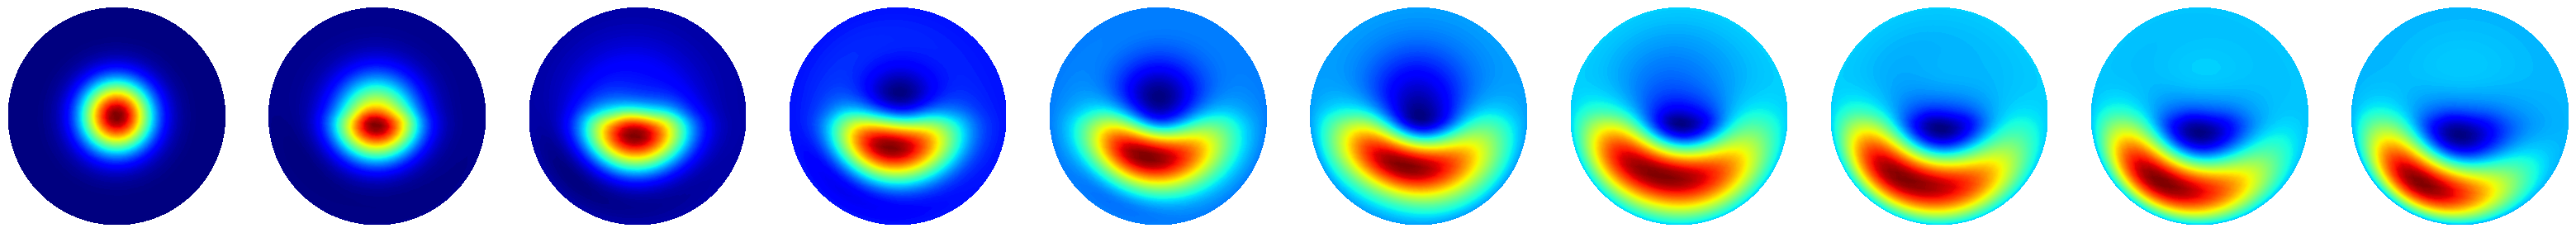

In [ ]:
fe.multiplot(uRB[:10, :Vh.dim()],(1,10),Vh)

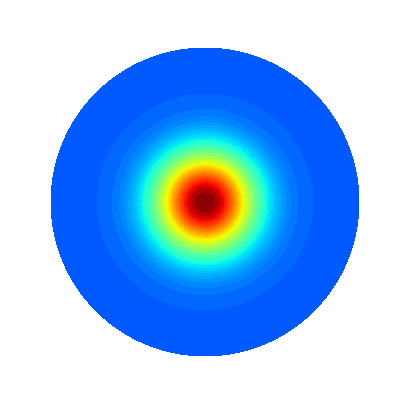

In [ ]:
fe.animate(uFOM[:, :Vh.dim()], Vh)


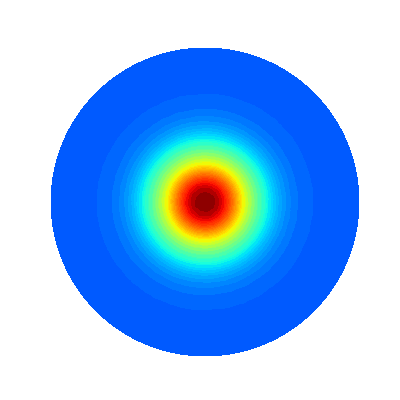

In [ ]:
fe.animate(uRB[:, :Vh.dim()], Vh)

0.020385006473352323


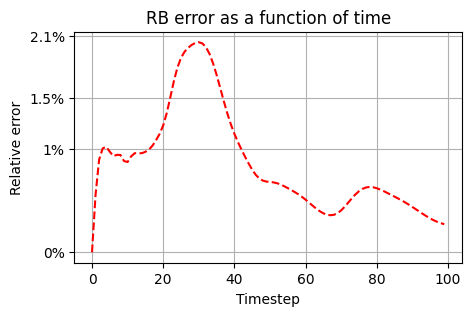

In [ ]:
errors = np.linalg.norm(uFOM-uRB, axis = 1)/np.linalg.norm(uFOM, axis = 1)
print(np.max(errors))
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.01, 0.015, 0.021], ["0%", "1%", "1.5%", "2.1%"])
plt.grid()
plt.show()


In [ ]:
prob_rb=probabilities(uRB)
print(prob_rb.shape)
caught_rb=caught(prob_rb)
print(caught_rb)

(100, 995)
0.9646810841198119


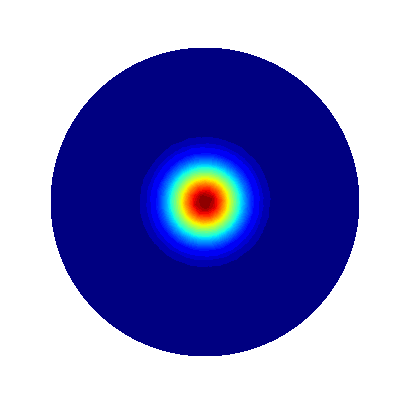

In [ ]:
fe.animate(prob_rb, Vh)

0.3696942148727438


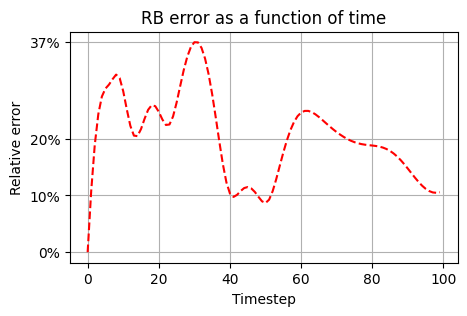

In [ ]:
errors = np.linalg.norm(prob-prob_rb, axis = 1)/np.linalg.norm(prob, axis = 1)
print(np.max(errors))
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.1, 0.2, 0.37], ["0%", "10%", "20%", "37%"])
plt.grid()
plt.show()

# Final Point
+ faccio 100 simulazioni in cui incremento di 10 il valore del potenziale $\Delta V_0 +=10$ fino ad arrivare ad un valore richiesto di $\Delta V_0=1000$ mentre $E=500$ rimane settato e calcolo le consecutive probabilità nel ciclo-for
+ richiesta ... della mappa ES. faccio un grafico $\Delta V_0$ vs $max(|\Psi^2|)=||\Psi^2||_{L_{\infty}}$


In [ ]:
param_list= []
u_rb_list=[]
prob_list=[]

for i in range (1,1000,10): #loop over the DeltaV0 from 1 to 1000 as requested!
  param=np.array([500,i])
  param_list.append(param)
  u_rb=RBsolver(param)
  u_rb_list.append(u_rb)
  prob_out=probabilities(u_rb)
  prob_list.append(prob_out)


param=np.array(param_list)
u_rb=np.array(u_rb_list)
prob_out=np.array(prob_list)
print(param.shape, u_rb.shape,prob_out.shape)

(100, 2) (100, 100, 1990) (100, 100, 995)


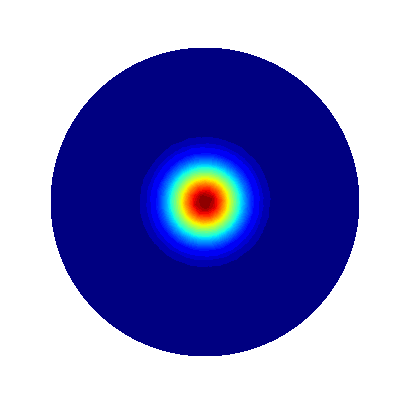

In [ ]:
fe.animate(prob_out[99,:,:],Vh) #100 simulazioni x 100 time-steps x 995 dofs della probabilità

# Probability Function
+ Plotto la media delle probabilità di trovare l'elettrone cioè $|\Psi^2|$ e la normalizzo al valore massimo cioè $\mathbb{P}=\frac{|\Psi^2|}{||\Psi^2||_{L_{\infty}}}$. La media si fa rispetto ai DoFs:
$$P=\frac{1}{995}\sum_i^{995}|\Psi^2|$$
+ plotto su un grafico 3D su un asse il numero di simulazioni (che corrisponde col valore di $\Delta V_{0_i}$ cioè del potenziale)
+ Plotto i time-steps su un ulteriore asse

In [ ]:
#max_dof_value = np.max(prob_out)
#print(max_dof_value)
gamma=np.array([[1,2,4],
              [4,5,10]])
print(gamma.shape)
np.max(gamma[:,2])


(2, 3)


np.int64(10)

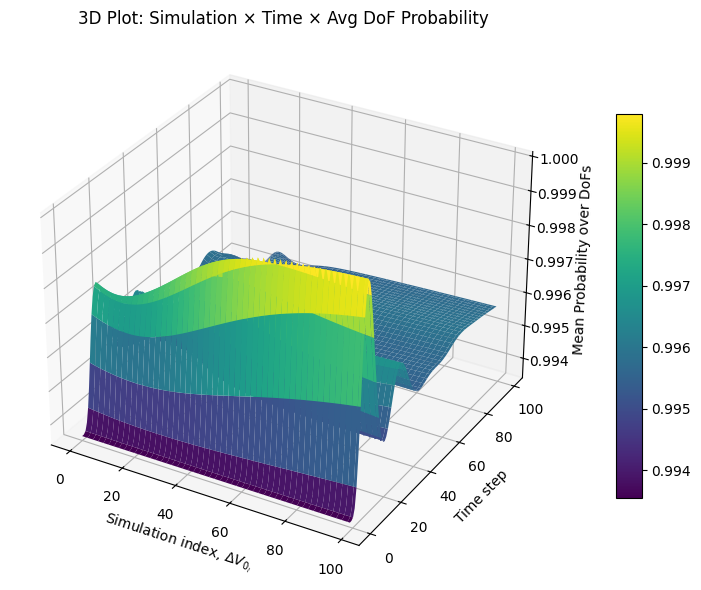

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Compute mean over DoFs → shape: (100 simulations, 100 time steps)
Z = np.mean(prob_out, axis=2)

# Build grid for plotting
sim_idx = np.arange(Z.shape[0])   # 0 to 99
time_idx = np.arange(Z.shape[1])  # 0 to 99
Sim, Time = np.meshgrid(sim_idx, time_idx, indexing='ij')  # shape: (100, 100)

# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Sim, Time, Z/np.max(Z), cmap='viridis') #normalizzazione della probabilità di trovare l'elettrone

# Labels
ax.set_xlabel("Simulation index, $\Delta V_{0_i}$")
ax.set_ylabel("Time step")
ax.set_zlabel("Mean Probability over DoFs")
ax.set_title("3D Plot: Simulation × Time × Avg DoF Probability")
fig.colorbar(surf, shrink=0.7, aspect=15)

plt.tight_layout()
plt.show()



# lower-bound presence of the electron $\texttt{caught(prob)}$
+ TO DO: valutare la funzione $\texttt{caught(prob)}$ che è la probabilità di trovare l'elettrone al bordo inferiore e bisogna farlo per ogni simulazione

(100, 100, 995)
0.4917955118872069


<ipython-input-274-5fbf7629f94c>:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  treshold=np.where(prob_c >= 0.9)


(100,)


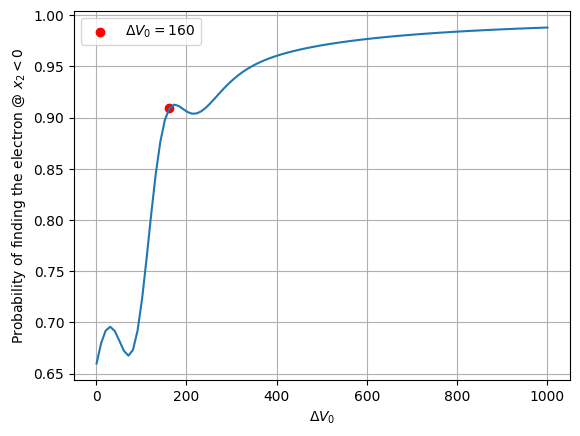

In [ ]:
print(prob_out.shape)
prob_c=caught(prob_out[0,0,:])
print(prob_c)

deltaV0=np.linspace(1,1000,100)
treshold=np.where(prob_c >= 0.9)

prob_c_list=[]
for i in range(100):
  for j in range(100):
    prob_c=caught(prob_out[i,j,:])
  prob_c_list.append(prob_c)

prob_c=np.array(prob_c_list)
print(prob_c.shape)
plt.plot(deltaV0,prob_c)
plt.scatter(deltaV0[16],prob_c[16],color='red',label="$\Delta V_0=$160")
plt.xlabel("$\Delta V_0$")
plt.ylabel("Probability of finding the electron @ $x_2 < 0$")
plt.grid()
plt.legend()
plt.show()